In [1]:
import os
import sys
sys.path.append('../utils')
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
import albumentations
from visdom import Visdom
from tqdm import tqdm

import segmentation_models_pytorch as smp
from datasets import ACDCDataset
from training import dice_loss, tversky_loss, ce_loss

EXP_NAME = 'unet-resnet50'
LOG_FILE = EXP_NAME + '.log'
VIS_FILE = EXP_NAME + '.vislog'

In [2]:
augmentation = albumentations.Compose([
    albumentations.OneOf([
        albumentations.GridDistortion(p=1.),
        albumentations.ElasticTransform(p=1.),
        albumentations.OpticalDistortion(p=1.),
        albumentations.ShiftScaleRotate(p=1.),
    ], p=.7),
    albumentations.RandomBrightnessContrast(p=.7),
    albumentations.RandomGamma(p=.7),
    albumentations.RandomRotate90(p=.7),
    albumentations.Rotate(p=1.),
    albumentations.VerticalFlip(p=.7),
    albumentations.HorizontalFlip(p=.7),
    albumentations.Transpose(p=.7),
    albumentations.CLAHE(p=1.),
    albumentations.Resize(256, 256),
])

dataset = ACDCDataset('../data/acdc/training', None, augmentation, preload=True)
train_dataset, val_dataset = dataset.split_train_val(train_size=0.7)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

In [3]:
len(train_dataset), len(val_dataset)

(1328, 574)

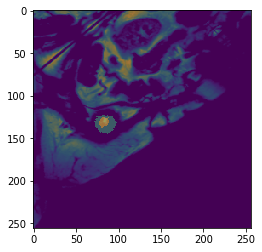

In [4]:
c, img, mask = dataset[79]
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
model = smp.Unet(encoder_name='resnet50', encoder_weights=None, in_channels=1, classes=4).to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)
criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
metric = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25

In [8]:
if not os.path.exists(os.path.join('chckpoints', EXP_NAME)):
    os.makedirs(os.path.join('chckpoints', EXP_NAME))

In [9]:
vis = Visdom(log_to_filename=VIS_FILE, offline=True)
train_losses = np.ones(100)
val_losses = np.ones(100)
for epoch in range(100):
    train_loss = 0.
    val_loss = 0.
    model.train()
    for _, images, targets in tqdm(train_generator, total=len(train_generator)):
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # backpropagate
        pred = model(images)
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(train_generator)
    torch.cuda.empty_cache()
    model.eval()
    for _, images, targets in tqdm(val_generator, total=len(val_generator)):
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            pred = model(images)
        loss = metric(pred, targets)
        val_loss += loss.item() / len(val_generator)
    if epoch % 10 == 0: torch.save(model.state_dict(), os.path.join('chckpoints', EXP_NAME, 'checkpoints_%d.pth' % epoch))
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    vis.line(X=[epoch], Y=[train_loss], win='loss curves', name='train', update='append')
    vis.line(X=[epoch], Y=[val_loss], win='loss curves', name='val', update='append')
    vis.line(X=[epoch], Y=[optimizer.param_groups[0]['lr']], win='loss curves', name='lr', update='append')
    print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())))
    with open(LOG_FILE, 'a') as _f:
        print('epoch: %d train loss: %.3f val loss: %.3f time: %s' % (epoch, train_loss, val_loss, str(datetime.datetime.now())), file=_f)
    if optimizer.param_groups[0]['lr'] < 2e-8:
        train_losses = train_losses[:epoch+1]
        val_losses = val_losses[:epoch+1]
        break

  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 0 train loss: 0.965 val loss: 0.834 time: 2020-05-10 13:28:27.744035


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 1 train loss: 0.768 val loss: 4.596 time: 2020-05-10 13:29:34.900150


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 2 train loss: 0.671 val loss: 0.665 time: 2020-05-10 13:30:42.723140


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 3 train loss: 0.598 val loss: 0.575 time: 2020-05-10 13:31:48.626870


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 4 train loss: 0.523 val loss: 0.510 time: 2020-05-10 13:32:54.397265


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 5 train loss: 0.457 val loss: 0.447 time: 2020-05-10 13:33:58.914865


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 6 train loss: 0.394 val loss: 0.370 time: 2020-05-10 13:35:04.770849


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 7 train loss: 0.333 val loss: 0.334 time: 2020-05-10 13:36:08.377847


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 8 train loss: 0.285 val loss: 0.266 time: 2020-05-10 13:37:15.036013


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 9 train loss: 0.254 val loss: 0.256 time: 2020-05-10 13:38:23.378220


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 10 train loss: 0.224 val loss: 0.185 time: 2020-05-10 13:39:27.597000


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 11 train loss: 0.201 val loss: 0.178 time: 2020-05-10 13:40:34.336089


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 12 train loss: 0.185 val loss: 0.187 time: 2020-05-10 13:41:39.204997


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 13 train loss: 0.177 val loss: 0.166 time: 2020-05-10 13:42:47.167216


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 14 train loss: 0.162 val loss: 0.161 time: 2020-05-10 13:43:53.342525


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 15 train loss: 0.166 val loss: 0.200 time: 2020-05-10 13:44:57.881715


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 16 train loss: 0.157 val loss: 0.161 time: 2020-05-10 13:46:04.901705


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 17 train loss: 0.153 val loss: 0.149 time: 2020-05-10 13:47:11.628735


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 18 train loss: 0.151 val loss: 0.132 time: 2020-05-10 13:48:14.566828


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 19 train loss: 0.147 val loss: 0.191 time: 2020-05-10 13:49:22.214302


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 20 train loss: 0.152 val loss: 0.135 time: 2020-05-10 13:50:28.198361


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 21 train loss: 0.142 val loss: 0.128 time: 2020-05-10 13:51:34.559857


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 22 train loss: 0.140 val loss: 0.139 time: 2020-05-10 13:52:41.734069


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 23 train loss: 0.132 val loss: 0.122 time: 2020-05-10 13:53:46.522739


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 24 train loss: 0.135 val loss: 0.112 time: 2020-05-10 13:54:50.043471


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 25 train loss: 0.128 val loss: 0.149 time: 2020-05-10 13:55:56.821863


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 26 train loss: 0.133 val loss: 0.110 time: 2020-05-10 13:57:00.119469


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 27 train loss: 0.130 val loss: 0.116 time: 2020-05-10 13:58:07.107722


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 28 train loss: 0.121 val loss: 0.123 time: 2020-05-10 13:59:11.534001


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 29 train loss: 0.123 val loss: 0.131 time: 2020-05-10 14:00:17.612966


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 30 train loss: 0.126 val loss: 0.126 time: 2020-05-10 14:01:25.992993


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 31 train loss: 0.121 val loss: 0.118 time: 2020-05-10 14:02:32.118447


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 32 train loss: 0.124 val loss: 0.122 time: 2020-05-10 14:03:39.490643


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 33 train loss: 0.121 val loss: 0.121 time: 2020-05-10 14:04:44.453681


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 34 train loss: 0.115 val loss: 0.116 time: 2020-05-10 14:05:49.398506


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 35 train loss: 0.120 val loss: 0.108 time: 2020-05-10 14:06:52.106332


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 36 train loss: 0.113 val loss: 0.104 time: 2020-05-10 14:07:57.469410


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 37 train loss: 0.114 val loss: 0.105 time: 2020-05-10 14:09:03.191245


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 38 train loss: 0.116 val loss: 0.107 time: 2020-05-10 14:10:08.427408


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 39 train loss: 0.112 val loss: 0.117 time: 2020-05-10 14:11:15.858378


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 40 train loss: 0.113 val loss: 0.120 time: 2020-05-10 14:12:20.542375


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 41 train loss: 0.115 val loss: 0.105 time: 2020-05-10 14:13:26.599821


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 42 train loss: 0.112 val loss: 0.108 time: 2020-05-10 14:14:33.048719


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 43 train loss: 0.114 val loss: 0.107 time: 2020-05-10 14:15:37.777769


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 44 train loss: 0.115 val loss: 0.112 time: 2020-05-10 14:16:45.367093


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 45 train loss: 0.112 val loss: 0.108 time: 2020-05-10 14:17:49.335493


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 46 train loss: 0.111 val loss: 0.108 time: 2020-05-10 14:18:52.895209


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 47 train loss: 0.106 val loss: 0.105 time: 2020-05-10 14:19:57.248587


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 48 train loss: 0.110 val loss: 0.114 time: 2020-05-10 14:21:03.036785


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 49 train loss: 0.111 val loss: 0.109 time: 2020-05-10 14:22:10.157673


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 50 train loss: 0.109 val loss: 0.107 time: 2020-05-10 14:23:19.681893


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 51 train loss: 0.110 val loss: 0.104 time: 2020-05-10 14:24:22.538823


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 52 train loss: 0.106 val loss: 0.106 time: 2020-05-10 14:25:26.644206


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 53 train loss: 0.108 val loss: 0.102 time: 2020-05-10 14:26:30.889365


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 54 train loss: 0.107 val loss: 0.109 time: 2020-05-10 14:27:38.682590


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 55 train loss: 0.102 val loss: 0.101 time: 2020-05-10 14:28:47.153621


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 56 train loss: 0.103 val loss: 0.098 time: 2020-05-10 14:29:52.825354


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 57 train loss: 0.108 val loss: 0.101 time: 2020-05-10 14:30:58.324684


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 58 train loss: 0.106 val loss: 0.095 time: 2020-05-10 14:32:00.736521


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 59 train loss: 0.106 val loss: 0.098 time: 2020-05-10 14:33:05.852673


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 60 train loss: 0.099 val loss: 0.104 time: 2020-05-10 14:34:11.465327


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 61 train loss: 0.104 val loss: 0.102 time: 2020-05-10 14:35:17.510252


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 62 train loss: 0.100 val loss: 0.095 time: 2020-05-10 14:36:21.009745


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 63 train loss: 0.109 val loss: 0.097 time: 2020-05-10 14:37:29.109361


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 64 train loss: 0.104 val loss: 0.103 time: 2020-05-10 14:38:38.078501


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 65 train loss: 0.100 val loss: 0.101 time: 2020-05-10 14:39:44.133421


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 66 train loss: 0.100 val loss: 0.102 time: 2020-05-10 14:40:50.319821


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 67 train loss: 0.101 val loss: 0.098 time: 2020-05-10 14:41:56.225214


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 68 train loss: 0.101 val loss: 0.099 time: 2020-05-10 14:43:01.161752


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 69 train loss: 0.094 val loss: 0.121 time: 2020-05-10 14:44:08.213994


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 70 train loss: 0.097 val loss: 0.100 time: 2020-05-10 14:45:17.328451


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 71 train loss: 0.104 val loss: 0.105 time: 2020-05-10 14:46:24.616710


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 72 train loss: 0.099 val loss: 0.093 time: 2020-05-10 14:47:29.705887


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 73 train loss: 0.101 val loss: 0.094 time: 2020-05-10 14:48:36.857821


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 74 train loss: 0.100 val loss: 0.100 time: 2020-05-10 14:49:44.337063


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 75 train loss: 0.095 val loss: 0.098 time: 2020-05-10 14:50:49.220887


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 76 train loss: 0.097 val loss: 0.103 time: 2020-05-10 14:51:55.478163


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 77 train loss: 0.099 val loss: 0.092 time: 2020-05-10 14:52:59.326520


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 78 train loss: 0.095 val loss: 0.107 time: 2020-05-10 14:54:04.513898


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 79 train loss: 0.099 val loss: 0.094 time: 2020-05-10 14:55:13.188670


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 80 train loss: 0.099 val loss: 0.121 time: 2020-05-10 14:56:19.360753


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 81 train loss: 0.097 val loss: 0.102 time: 2020-05-10 14:57:23.909022


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 82 train loss: 0.102 val loss: 0.117 time: 2020-05-10 14:58:27.244373


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 83 train loss: 0.095 val loss: 0.104 time: 2020-05-10 14:59:35.586804


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 84 train loss: 0.103 val loss: 0.100 time: 2020-05-10 15:00:43.662238


  0%|          | 0/21 [00:00<?, ?it/s]

epoch: 85 train loss: 0.099 val loss: 0.097 time: 2020-05-10 15:01:49.736847


 71%|███████▏  | 15/21 [00:36<00:14,  2.44s/it]


KeyboardInterrupt: 

In [ ]:
# model.load_state_dict(torch.load('chckpoints/unet-densenet121/checkpoints_40.pth'))
model = torch.load('unet-densenet161.pth').to(device)

In [10]:
torch.cuda.empty_cache()

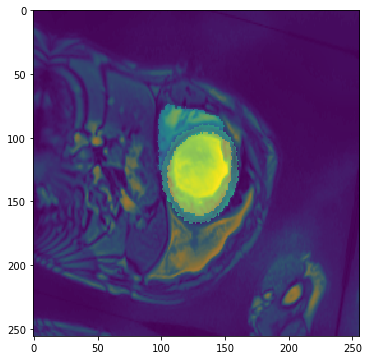

In [13]:
c, img, mask = val_dataset[24]

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(mask.numpy()[0], alpha=0.5)
plt.show()

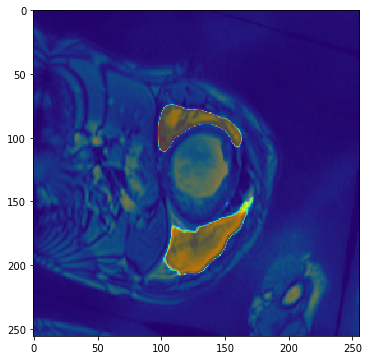

In [14]:
model.eval()
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))[0]
probas = torch.nn.functional.softmax(pred, dim=0)

plt.figure(figsize=(6,6))
plt.imshow(img.numpy()[0])
plt.imshow(probas.cpu().numpy()[1], alpha=0.5, cmap=plt.cm.jet)
plt.show()

In [15]:
torch.save(model, 'unet-resnet50.pth')